In [6]:
# Import Stuff
import math
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt

import tensorflow.contrib.learn as skflow
# from tensorflow import estimator
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.python.data import Dataset

from sklearn import metrics
from sklearn.model_selection import train_test_split



import logging
logging.basicConfig(level=logging.INFO)
logging.info('Tensorflow %s' % tf.__version__) # 1.4.1

INFO:root:Tensorflow 1.12.0


In [1]:
def linear_scale(series):
    """Applies min-max scaling to inputs"""
    min_val = series.min()
    max_val = series.max()
    scale = (max_val - min_val) / 2.0
    return series.apply(lambda x:((x - min_val) / scale) - 1.0)

def log_normalize(series):
    return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
    return series.apply(lambda x:(
        min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
    mean = series.mean()
    std_dv = series.std()
    return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
    return series.apply(lambda x:(1 if x > threshold else 0))

def normalize(examples_dataframe):
    """Returns a version of the input `DataFrame` that has all its features normalized."""
    processed_features = pd.DataFrame()
    for column in examples_dataframe.columns:
        if "windSpeed" or "Size" in column:
            processed_features[column] = log_normalize(examples_dataframe[column]).astype('float32')
        else:
            processed_features[column] = linear_scale(examples_dataframe[column]).astype('float32')
    return processed_features

def inv_log_normalize(series):
    return series.apply(lambda x: math.exp(x)-1.0)

In [2]:
def ignitionIndex(column_name):
    return int(column_name
               .replace("summary", "")
               .replace("precipType", "")
               .replace("temperature", "")
               .replace("apparentTemperature", "")
               .replace("dewPoint", "")
               .replace("humidity", "")
               .replace("pressure", "")
               .replace("windSpeed", "")
               .replace("windGust", "")
               .replace("windBearing", "")
               .replace("cloudCover", "")
               .replace("uvIndex", "")
               .replace("visibility", "")
               .replace("precipIntensity", "")
               .replace("precipProbability", "")
               .replace("_", ""))
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

In [3]:
def construct_feature_columns(input_features):
    """Construct the TensorFlow Feature Columns.
    Args:
        input_features: The names of the numerical input features to use.
    Returns:
        A set of feature columns
    """ 
    return set([tf.feature_column.numeric_column(my_feature)
                  for my_feature in input_features.columns])

In [4]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.

    Args:
        features: pandas DataFrame of features
        targets: pandas DataFrame of targets
        batch_size: Size of batches to be passed to the model
          shuffle: True or False. Whether to shuffle the data.
        num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
        Tuple of (features, labels) for next data batch
    """

    # Convert pandas data into a dict of np arrays.
    features = {key: np.array(value) for key, value in dict(features).items()}

    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features, targets))  # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(10)

    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [5]:
def preprocess_data(wildfire_dataframe):
    """Prepares input features from California housing data seArgs:
    df: A Pandas DataFrame expected to contain data
      from the training.training wildfire collection.
      Returns:
        A DataFrame that contains the features to be used for the model, including
        synthetic features.
    """
    """Prepares target features (i.e., labels) from the wildfire data set.
    Args: 
        wildfire_dataframe: A Pandas DataFrame expected to contain data
        from the training.training wildfire collection.
    Returns:
       A DataFrame that contains the target feature.
    """
    df = wildfire_dataframe.copy()
    df = df.drop(columns=['Costs'])
    descriptive_features = ["temperature", "windSpeed", "humidity"]
    target_features = ["Size"]
    all_features = descriptive_features+target_features

    # get rid of columns not in all_features
    cols = filter(lambda col: (not hasNumbers(col) or (hasNumbers(col) and ignitionIndex(col) % 24 == 0))
                  and any(map(lambda k: k in col, all_features)),
                 [col for col in df.columns])
#     cols = filter(lambda col: any(map(lambda k: k in col, all_features)),
#                  [col for col in df.columns])
    df = df[cols]
    
    # remove all rows containing a NaN in any column from all_features
    df = df.dropna()
    all_test_targets = df[["Size"]].copy()
    training_length = math.floor(len(df.index) * .80)
    rest_size = len(df[training_length:].index)
    
    # extract descriptive and target features 
    # to construct training and validation datasets
    training_df = df.copy()[0:training_length]
    validation_df = df.copy()[training_length:training_length+math.floor(rest_size/2)]
    test_df = df.copy()[training_length+math.floor(rest_size/2):]
    
    def process_df(training_df):
        features = training_df.drop(columns=target_features)
        targets = training_df[target_features]
        return features, targets
    
    training_features, training_targets = process_df(training_df)    
    validation_features, validation_targets = process_df(validation_df)
    test_features, test_targets = process_df(test_df)
    
    return training_features,\
            training_targets,\
            validation_features,\
            validation_targets,\
            test_features,\
            test_targets, \
            all_test_targets

c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5,18,31,44,57,70,83,96,109,122,135,148,161,174,187,200,213,226,239,252,265,278,291,304,317,330,343,356,369,382,395,408,421,434,447,460,473,486,499,512,525,538,551,564,577,590,603,616,629,642,655,668,681,694,707,720,733,746,759,772,785,798,811,824,837,850,863,876,889,902,915,928,941,954,967,980,993,1006,1019,1032,1045,1058,1071,1084,1097,1110,1123,1136,1149,1162,1175,1188,1201,1214,1227,1240,1253,1266,1279,1292,1305,1318,1331,1344,1357,1370,1383,1396,1409,1422,1435,1448,1461,1474,1487,1500,1513,1526,1539,1552,1565,1578,1591,1604,1617,1630,1643,1656,1669,1682,1695,1708,1721,1734,1747,1760,1772,1784,1796,1808,1821,1834,1847,1860,1873,1886,1899,1912,1925,1938,1951,1964,1977,1990,2003,2016,2029,2044,2057,2070,2083,2096,2109,2122,2135,2148,2161,2174,2187,2200,2213,2226,2253,2266,2279,2292,2305,2318,2331,2372,2385,2398,2411,2424,2437,2450,2463,2476,2489,2502,25

Training examples summary:
       temperature_336  humidity_336  windSpeed_336  temperature_312  \
count      1460.000000   1460.000000    1460.000000      1460.000000   
mean         61.065719      0.574945       1.770274        61.141397   
std           9.664100      0.220239       2.058314         9.534482   
min          27.760000      0.060000       0.000000        26.610000   
25%          54.970000      0.390000       0.540000        55.017500   
50%          61.190000      0.550000       1.100000        61.080000   
75%          67.612500      0.760000       2.300000        67.602500   
max          96.500000      1.000000      19.990000        96.580000   

       humidity_312  windSpeed_312  temperature_288  humidity_288  \
count   1460.000000    1460.000000      1460.000000   1460.000000   
mean       0.572740       1.681459        61.381295      0.569178   
std        0.213177       1.915757         9.493237      0.208901   
min        0.090000       0.000000        28.750

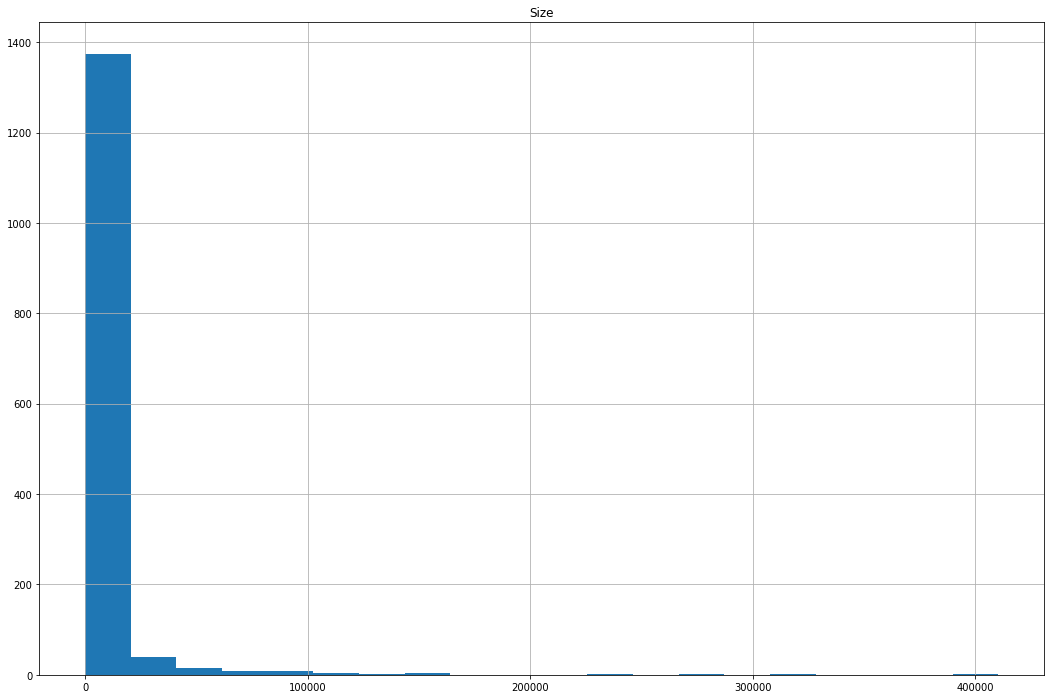

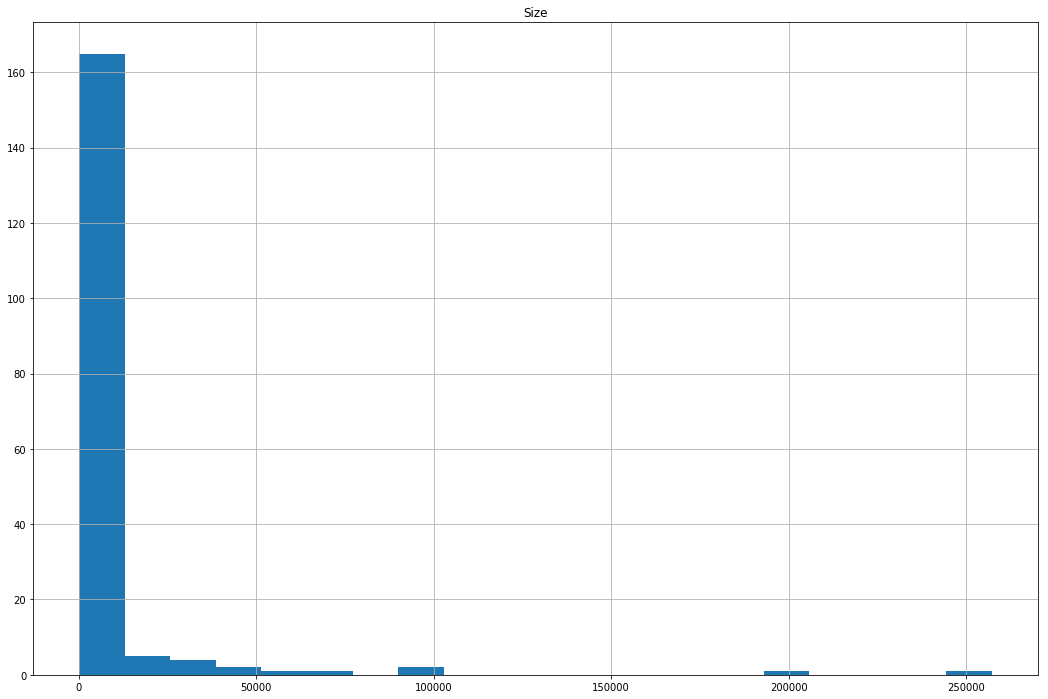

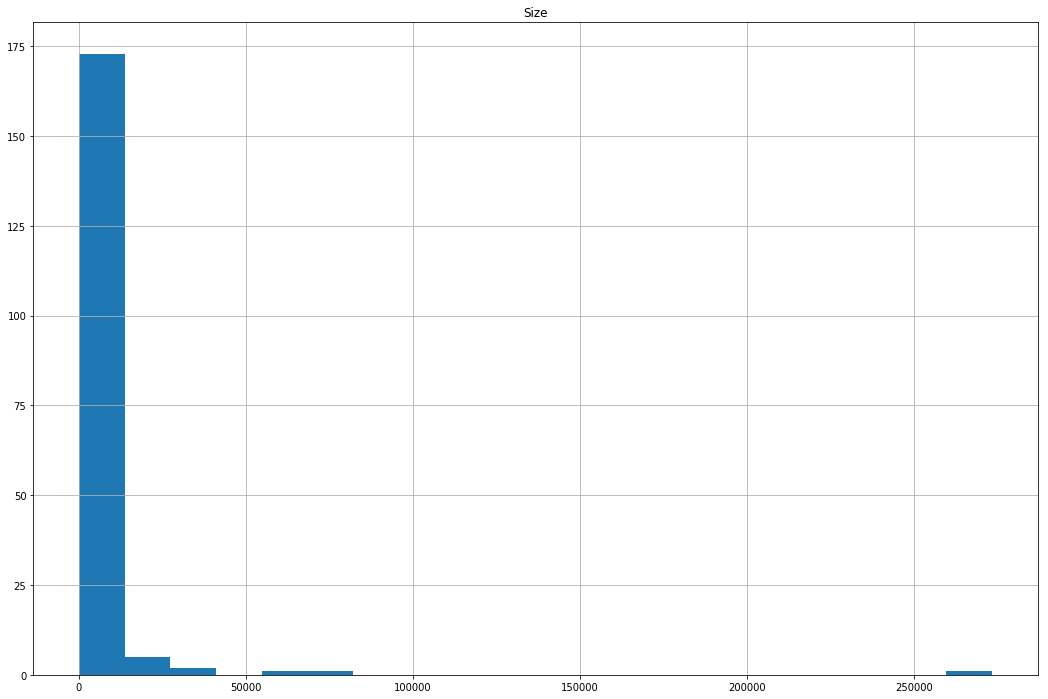

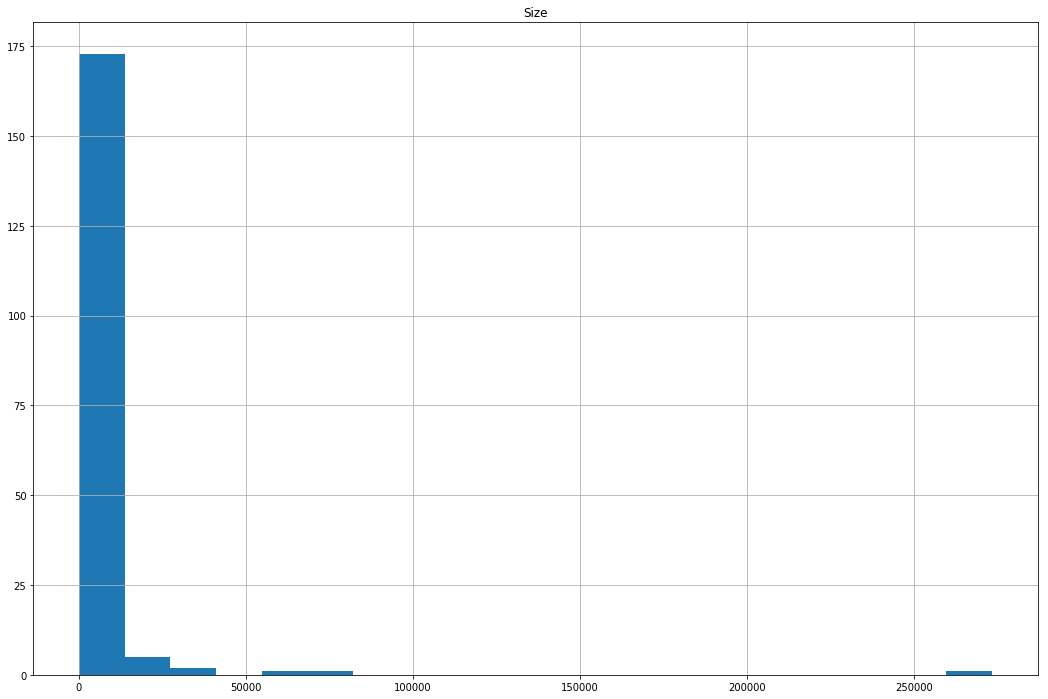

In [7]:
# load the data
csv_path = r"C:\Users\Ricky\Documents\MATH 4025 Applied Math Capstone\predicting-wildfire-risk\data\wildfire_events_full.csv"
df = pd.read_csv(csv_path)

RUN_NAME = "run_2"

# randomize the data
df = df.reindex(np.random.permutation(df.index))
# construct training and validation examples
X_train,y_train,X_valid,y_valid,X_test,y_test, y_test_all = preprocess_data(df)

# training_features,training_targets,validation_features,validation_targets,test_features,test_targets = preprocess_data(df)

# X_train.to_csv('.\\data\\'+RUN_NAME+'\\X_train.csv')
# y_train.to_csv('.\\data\\'+RUN_NAME+'\\y_train.csv')

# X_valid.to_csv('.\\data\\'+RUN_NAME+'\\X_valid.csv')
# y_valid.to_csv('.\\data\\'+RUN_NAME+'\\y_valid.csv')

# X_test.to_csv('.\\data\\'+RUN_NAME+'\\X_test.csv')
# y_test.to_csv('.\\data\\'+RUN_NAME+'\\y_test.csv')

# y_test_all.to_csv('.\\data\\'+RUN_NAME+'\\y_test_all.csv')

y_train_hist = y_train.hist(bins=20, figsize=(18, 12), xlabelsize=10)
# plt.savefig('.\\data\\'+RUN_NAME+'\\y_train_hist.png')
y_valid_hist = y_valid.hist(bins=20, figsize=(18, 12), xlabelsize=10)
# plt.savefig('.\\data\\'+RUN_NAME+'\\y_valid_hist.png')
y_test_hist = y_test.hist(bins=20, figsize=(18, 12), xlabelsize=10)
# plt.savefig('.\\data\\'+RUN_NAME+'\\y_test_hist.png')
y_test_all_hist = y_test.hist(bins=20, figsize=(18, 12), xlabelsize=10)
# plt.savefig('.\\data\\'+RUN_NAME+'\\y_test_all_hist.png')

# Double-check that we've done the right thing.
print("Training examples summary:")
print(X_train.describe())
print("Validation examples summary:")
print(X_valid.describe())
print("Test examples summary:")
print(X_test.describe())

print("Training targets summary:")
print(y_train.describe())
print("Validation targets summary:")
print(y_valid.describe())
print("Test targets summary:")
print(y_test.describe())

print("All test targets summary:")
print(y_test_all.describe())


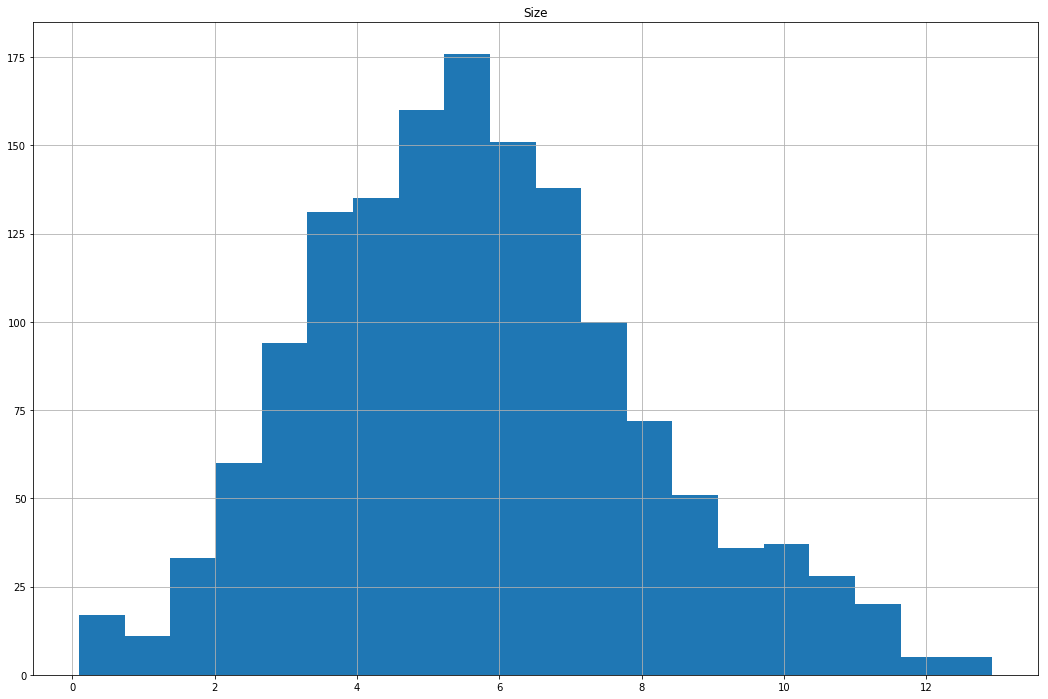

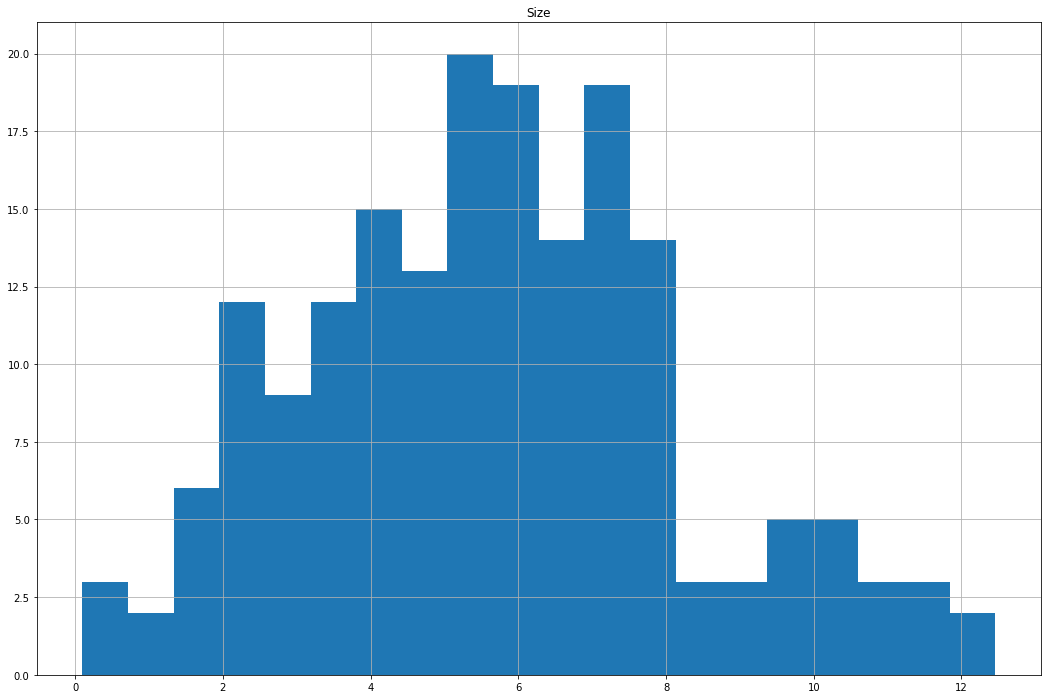

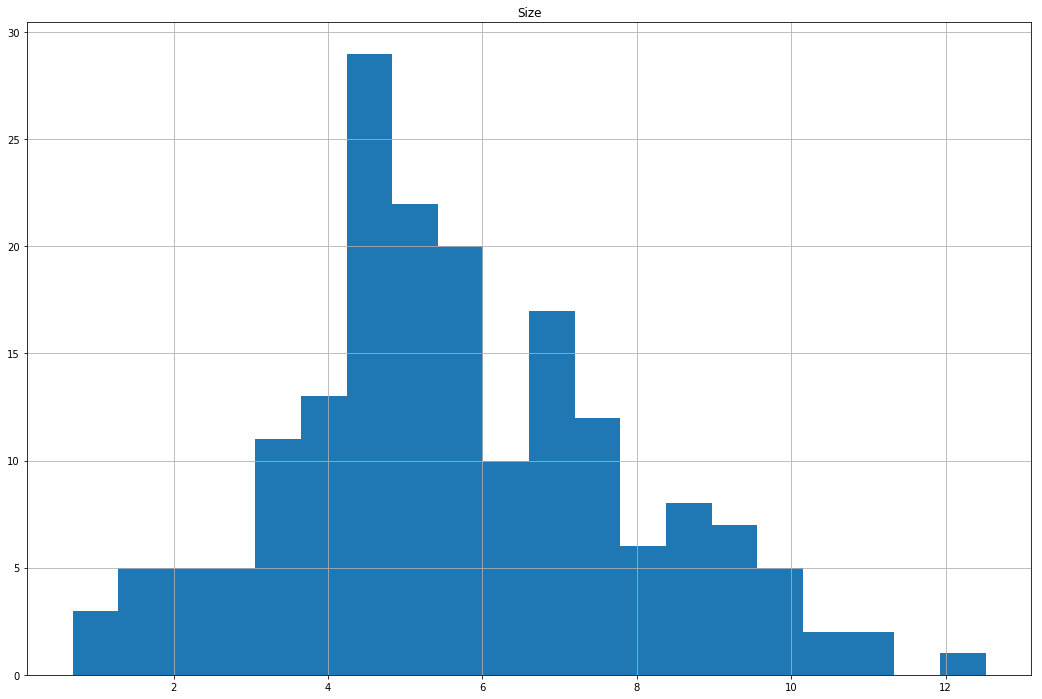

In [20]:
norm_X_train = normalize(X_train)
norm_X_valid = normalize(X_valid)
norm_X_test = normalize(X_test)

norm_y_train = normalize(y_train)
norm_y_valid = normalize(y_valid)
norm_y_test = normalize(y_test)


norm_X_train.to_csv('.\\data\\'+RUN_NAME+'\\norm_X_train.csv')
norm_y_train.to_csv('.\\data\\'+RUN_NAME+'\\norm_y_train.csv')

norm_X_valid.to_csv('.\\data\\'+RUN_NAME+'\\norm_X_valid.csv')
norm_y_valid.to_csv('.\\data\\'+RUN_NAME+'\\norm_y_valid.csv')

norm_X_test.to_csv('.\\data\\'+RUN_NAME+'\\norm_X_test.csv')
norm_y_test.to_csv('.\\data\\'+RUN_NAME+'\\norm_y_test.csv')

norm_y_train_hist = norm_y_train.hist(bins=20, figsize=(18, 12), xlabelsize=10)
plt.savefig('.\\data\\'+RUN_NAME+'\\norm_y_train_hist.png')
norm_y_valid_hist = norm_y_valid.hist(bins=20, figsize=(18, 12), xlabelsize=10)
plt.savefig('.\\data\\'+RUN_NAME+'\\norm_y_valid_hist.png')
norm_y_test_hist = norm_y_test.hist(bins=20, figsize=(18, 12), xlabelsize=10)
plt.savefig('.\\data\\'+RUN_NAME+'\\norm_y_test_hist.png')

In [21]:
# Defining the Tensorflow input functions
# for training

# training_input_fn = lambda: my_input_fn(norm_X_train, 
#                                       y_train["Size"], 
#                                       batch_size=batch_size)

def training_input_fn(batch_size=1):
    return lambda: my_input_fn(norm_X_train, 
                                      norm_y_train["Size"], 
                                      batch_size=batch_size)

def validation_input_fn(batch_size=1):
    return lambda: my_input_fn(norm_X_valid, 
                                            norm_y_valid["Size"], 
                                            num_epochs=1, 
                                            shuffle=False)

# def training_input_fn(batch_size=1):
# 	return tf.estimator.inputs.numpy_input_fn(
# 					x={'X': X_train.astype(np.float32)},
# 					y=y_train.astype(np.float32),
# 					batch_size=batch_size,
# 					num_epochs=None,
# 					shuffle=True)
# # for test
# def test_input_fn():
# 	return tf.estimator.inputs.numpy_input_fn(
# 				  	x={'X': X_test.astype(np.float32)},
# 				  	y=y_test.astype(np.float32),
# 				  	num_epochs=1,
# 				  	shuffle=False)

In [22]:
# Network Design
# --------------
# feature_columns = [tf.feature_column.numeric_column('X', shape=(1,))]

# norm_X_test = pd.read_csv('.\\data\\'+RUN_NAME+'\\norm_X_test.csv')
# norm_y_test = pd.read_csv('.\\data\\'+RUN_NAME+'\\norm_y_test.csv')

feature_columns = construct_feature_columns(norm_X_train)

STEPS_PER_EPOCH = 100
EPOCHS = 100
BATCH_SIZE = 100


# hidden_layers = [math.floor(len(norm_X_train.columns)/8)]
hidden_layers = [10]
print(hidden_layers)
dropout = 0.0

# MODEL_PATH='./models/DNNRegressors/run_1/87_D05'
# MODEL_PATH='./models/DNNRegressors/'+RUN_NAME+'/'
MODEL_PATH='./models/DNNRegressors/'+RUN_NAME+'/10_D00'
# for hl in hidden_layers:
# 	MODEL_PATH += '%s_' % hl
# MODEL_PATH += 'D0%s' % (int(dropout*10))
# logging.info('Saving to %s' % MODEL_PATH)

# Validation and Test Configuration
# validation_metrics = {"MSE": tf.contrib.metrics.streaming_mean_squared_error}
validation_metrics = {"RMSE": tf.contrib.metrics.streaming_root_mean_squared_error}
test_config = skflow.RunConfig(save_checkpoints_steps=100,
				save_checkpoints_secs=None)

# Create the optimizer
my_optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
# my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Building the Network
regressor = skflow.DNNRegressor(feature_columns=feature_columns,
# regressor = estimator.DNNRegressor(feature_columns=feature_columns,
				label_dimension=1,
                optimizer=my_optimizer,
				hidden_units=hidden_layers,
				model_dir=MODEL_PATH,
#                 warm_start_from=MODEL_PATH
				dropout=dropout,
				config=test_config)


[10]


In [71]:
TRAINING = True
WITHPLOT = False

# Train it
if TRAINING:
	logging.info('Train the DNN Regressor...\n')
	MSEs = []	# for plotting
	STEPS = []	# for plotting

	for epoch in range(EPOCHS+1):

		# Fit the DNNRegressor (This is where the magic happens!!!)
		regressor.fit(input_fn=training_input_fn(batch_size=BATCH_SIZE),
				steps=STEPS_PER_EPOCH)
		# Thats it -----------------------------
		# Start Tensorboard in Terminal:
		# 	tensorboard --logdir='./models/DNNRegressors/'
		# Now open Browser and visit localhost:6006\

		
		# This is just for fun and educational purpose:
		# Evaluate the DNNRegressor every 10th epoch
		if epoch%10==0:
			eval_dict = regressor.evaluate(input_fn=validation_input_fn(),
							metrics=validation_metrics)
# 			print(eval_dict)
			print('Epoch %i: %.5f RMSE' % (epoch+1, eval_dict['RMSE']))


			if WITHPLOT:
				# Generate a plot for this epoch to see the Network learning
				y_pred = regressor.predict(x={'X': X}, as_iterable=False)

				E = (y.reshape((1,-1))-y_pred)
				MSE = np.mean(E**2.0)
				step = (epoch+1) * STEPS_PER_EPOCH
				title_string = '%s DNNRegressor after %06d steps (MSE=%.5f)' % \
								(MODEL_PATH.split('/')[-1], step, MSE)
				
				MSEs.append(MSE)
				STEPS.append(step)

				fig = plt.figure(figsize=(9,4))
				ax1 = fig.add_subplot(1, 4, (1, 3))
				ax1.plot(X, y, label='function to predict')
				ax1.plot(X, y_pred, label='DNNRegressor prediction')
				ax1.legend(loc=2)
				ax1.set_title(title_string)
				ax1.set_ylim([0, 1])

				ax2 = fig.add_subplot(1, 4, 4)
				ax2.plot(STEPS, MSEs)
				ax2.set_xlabel('Step')
				ax2.set_xlim([0, EPOCHS*STEPS_PER_EPOCH])
				ax2.set_ylabel('Mean Square Error')
				ax2.set_ylim([0, 0.01])

				plt.tight_layout()
				plt.savefig(MODEL_PATH + '_%05d.png' % (epoch+1), dpi=72)
				logging.info('Saved %s' % MODEL_PATH + '_%05d.png' % (epoch+1))

				plt.close()

    # Now it's trained. We can try to predict some values.
else:
    logging.info('No training today, just prediction')
    try:
        # Prediction
        print(norm_X_test)
        predict_targets = norm_y_test["Size"]
        print(predict_targets)
        predict_test_input_fn = lambda: my_input_fn(norm_X_test, 
                                                      predict_targets, 
                                                      num_epochs=1, 
                                                      shuffle=False)
        test_predictions = regressor.predict(input_fn=predict_test_input_fn)
#         print(test_predictions)
        print([item for item in test_predictions])
#         test_predictions = np.array([item['predictions'][0] for item in test_predictions])
#         test_errors = []
#         y_test_np = np.array(predict_targets)
        
#         for i in range(len(test_predictions)):
#             test_errors.append(y_test_np[i] - test_predictions[i])

#         print("predictions:")
#         print(test_predictions)
#         print("errors:")
#         print(test_errors)


#         test_root_mean_squared_error = math.sqrt(
#                 metrics.mean_squared_error(predict_targets, test_predictions))

#         print("Adam Optimizer RMSE (on test data):")
#         print(test_root_mean_squared_error)

#         test_r2_score = metrics.r2_score(predict_targets, test_predictions)

#         print("Adam Optimizer R^2 (on test data):")
#         print(test_r2_score)

        # Final Plot
        if WITHPLOT:
            plt.plot(X, y, label='function to predict')
            plt.plot(X, regressor.predict(x={'X': X}, as_iterable=False), \
                     label='DNNRegressor prediction')
            plt.legend(loc=2)
            plt.ylim([0, 1])
            plt.title('%s DNNRegressor' % MODEL_PATH.split('/')[-1])
            plt.tight_layout()
            plt.savefig(MODEL_PATH + '.png', dpi=72)
            plt.close()
    except:
        logging.Error('Prediction failed! Maybe first train a model?')

INFO:root:Train the DNN Regressor...



Epoch 1: 2.38204 RMSE
Epoch 11: 2.37829 RMSE
Epoch 21: 2.38586 RMSE
Epoch 31: 2.39684 RMSE
Epoch 41: 2.39109 RMSE
Epoch 51: 2.38451 RMSE
Epoch 61: 2.39316 RMSE
Epoch 71: 2.43632 RMSE
Epoch 81: 2.39862 RMSE
Epoch 91: 2.40827 RMSE
Epoch 101: 2.40797 RMSE


In [23]:
# Get trained values out of the Network
for variable_name in regressor.get_variable_names():
    if str(variable_name).startswith('dnn/hiddenlayer') and \
    (str(variable_name).endswith('weights') or \
         str(variable_name).endswith('biases')):
        print('\n%s:' % variable_name)
        weights = regressor.get_variable_value(variable_name)
        print(weights)
        print('size: %i' % weights.size)


dnn/hiddenlayer_0/biases:
[ 0.   -0.01 -0.14 -0.02  0.    0.    0.13  0.17  0.13  0.  ]
size: 10

dnn/hiddenlayer_0/weights:
[[-7.04e-02 -2.43e-01  1.59e-01  6.63e-02 -2.33e-01  7.28e-02 -3.93e-01
  -7.89e-01 -1.05e-01 -9.40e-02]
 [ 4.14e-02  1.79e-01  5.07e-01 -1.20e-01 -1.22e-01  2.07e-01 -1.68e-01
  -2.91e-01 -2.12e-01 -1.21e-01]
 [-1.67e-01  2.78e-02  1.16e-01  7.01e-02 -1.78e-01 -1.18e-01  1.08e-01
   2.37e-02 -1.42e-01 -1.76e-01]
 [-1.05e-01 -4.36e-02  3.85e-02  1.09e-01 -1.01e-01  1.38e-01 -3.74e-01
  -1.84e-01 -1.77e-01  1.17e-01]
 [ 1.89e-01 -2.33e-01 -1.33e-01  2.19e-01  7.37e-02  4.88e-02  6.44e-01
   4.13e-01  5.01e-01  3.80e-02]
 [-2.34e-01 -4.22e-03 -3.49e-01 -9.59e-02  2.60e-02 -1.07e-02  1.69e-01
   3.26e-01  2.52e-01  2.18e-02]
 [-2.35e-01 -8.76e-02  5.07e-01  1.76e-01 -1.23e-01 -4.43e-02 -1.06e+00
  -2.26e+00 -1.01e+00 -4.00e-03]
 [ 1.64e-01 -1.34e-01  5.37e-02 -4.37e-02  1.38e-01 -2.33e-01  3.07e-01
   5.64e-01  5.34e-01 -8.98e-02]
 [-2.41e-01 -1.90e-01 -2.31e-01  7

In [24]:
# from tensorflow.contrib import predictor

# MODEL_PATH='./models/DNNRegressors/10_D05'

# unnormalized_predict_targets = inv_log_normalize(norm_y_test["Size"])
unnormalized_predict_targets = y_test["Size"]
normalized_predict_targets = norm_y_test["Size"]


def predict_test_input_fn(batch_size=1):
    return lambda: my_input_fn(norm_X_test, 
                                            normalized_predict_targets, 
                                            num_epochs=1,
                                            batch_size=batch_size,
                                            shuffle=False)

normalized_test_predictions = regressor.predict(input_fn=predict_test_input_fn(batch_size=len(normalized_predict_targets)+2), as_iterable=False)

# predict_fn = predictor.from_saved_model(MODEL_PATH)
# normalized_test_predictions = predict_fn(predict_test_input_fn(batch_size=len(normalized_predict_targets)+2)())


# print("normalized_predict_targets:")
# print(normalized_predict_targets)

# print("normalized_test_predictions:")
# print(normalized_test_predictions)
# print(len(normalized_test_predictions))

normalized_test_mae = metrics.mean_absolute_error(normalized_predict_targets, normalized_test_predictions)

print("Adam Optimizer MAE (on normalized test data):")
print(normalized_test_mae)

normalized_test_rmse = math.sqrt(
        metrics.mean_squared_error(normalized_predict_targets, normalized_test_predictions))

print("Adam Optimizer RMSE (on normalized test data):")
print(normalized_test_rmse)


unnormalized_test_predictions = list(map(lambda x: math.exp(x)-1, normalized_test_predictions))
# unnormalized_test_predictions = inv_log_normalize(normalized_test_predictions)

# print("unnormalized_test_predictions:")
# print(unnormalized_test_predictions)
# print(len(unnormalized_test_predictions))

unnormalized_test_mae = metrics.mean_absolute_error(unnormalized_predict_targets, unnormalized_test_predictions)

print("Adam Optimizer MAE (on unnormalized test data):")
print(unnormalized_test_mae)

unnormalized_test_rmse = math.sqrt(
        metrics.mean_squared_error(unnormalized_predict_targets, unnormalized_test_predictions))

print("Adam Optimizer RMSE (on unnormalized test data):")
print(unnormalized_test_rmse)

# test_r2_score = metrics.r2_score(predict_targets, test_predictions)

# print("Adam Optimizer R^2 (on test data):")
# print(test_r2_score)

InternalError: Blas GEMM launch failed : a.shape=(183, 87), b.shape=(87, 10), m=183, n=10, k=87
	 [[node dnn/hiddenlayer_0/MatMul (defined at c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tensorflow\contrib\layers\python\layers\layers.py:1854)  = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dnn/input_from_feature_columns/input_layer/concat, dnn/hiddenlayer_0/weights/part_0/read)]]

Caused by op 'dnn/hiddenlayer_0/MatMul', defined at:
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\asyncio\base_events.py", line 421, in run_forever
    self._run_once()
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\asyncio\base_events.py", line 1431, in _run_once
    handle._run()
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tornado\gen.py", line 781, in inner
    self.run()
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tornado\gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-d65105860880>", line 17, in <module>
    normalized_test_predictions = regressor.predict(input_fn=predict_test_input_fn(batch_size=len(normalized_predict_targets)+2), as_iterable=False)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\util\deprecation.py", line 553, in new_func
    return func(*args, **kwargs)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\util\deprecation.py", line 553, in new_func
    return func(*args, **kwargs)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tensorflow\contrib\learn\python\learn\estimators\dnn.py", line 743, in predict
    as_iterable=as_iterable)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\util\deprecation.py", line 553, in new_func
    return func(*args, **kwargs)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tensorflow\contrib\learn\python\learn\estimators\dnn.py", line 779, in predict_scores
    as_iterable=as_iterable)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tensorflow\contrib\learn\python\learn\estimators\estimator.py", line 671, in predict
    iterate_batches=iterate_batches)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tensorflow\contrib\learn\python\learn\estimators\estimator.py", line 969, in _infer_model
    infer_ops = self._get_predict_ops(features)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tensorflow\contrib\learn\python\learn\estimators\estimator.py", line 1315, in _get_predict_ops
    return self._call_model_fn(features, labels, model_fn_lib.ModeKeys.INFER)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tensorflow\contrib\learn\python\learn\estimators\estimator.py", line 1228, in _call_model_fn
    model_fn_results = self._model_fn(features, labels, **kwargs)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tensorflow\contrib\learn\python\learn\estimators\dnn.py", line 177, in _dnn_model_fn
    scope=hidden_layer_scope)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tensorflow\contrib\framework\python\ops\arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tensorflow\contrib\layers\python\layers\layers.py", line 1854, in fully_connected
    outputs = layer.apply(inputs)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 817, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\layers\base.py", line 374, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 757, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\layers\core.py", line 970, in call
    outputs = gen_math_ops.mat_mul(inputs, self.kernel)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 4857, in mat_mul
    name=name)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InternalError (see above for traceback): Blas GEMM launch failed : a.shape=(183, 87), b.shape=(87, 10), m=183, n=10, k=87
	 [[node dnn/hiddenlayer_0/MatMul (defined at c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\tensorflow\contrib\layers\python\layers\layers.py:1854)  = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dnn/input_from_feature_columns/input_layer/concat, dnn/hiddenlayer_0/weights/part_0/read)]]
